In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from nonlocalgames.hamiltonians import G14

In [3]:
sns.set_context("poster")

## Plot G14 Graph

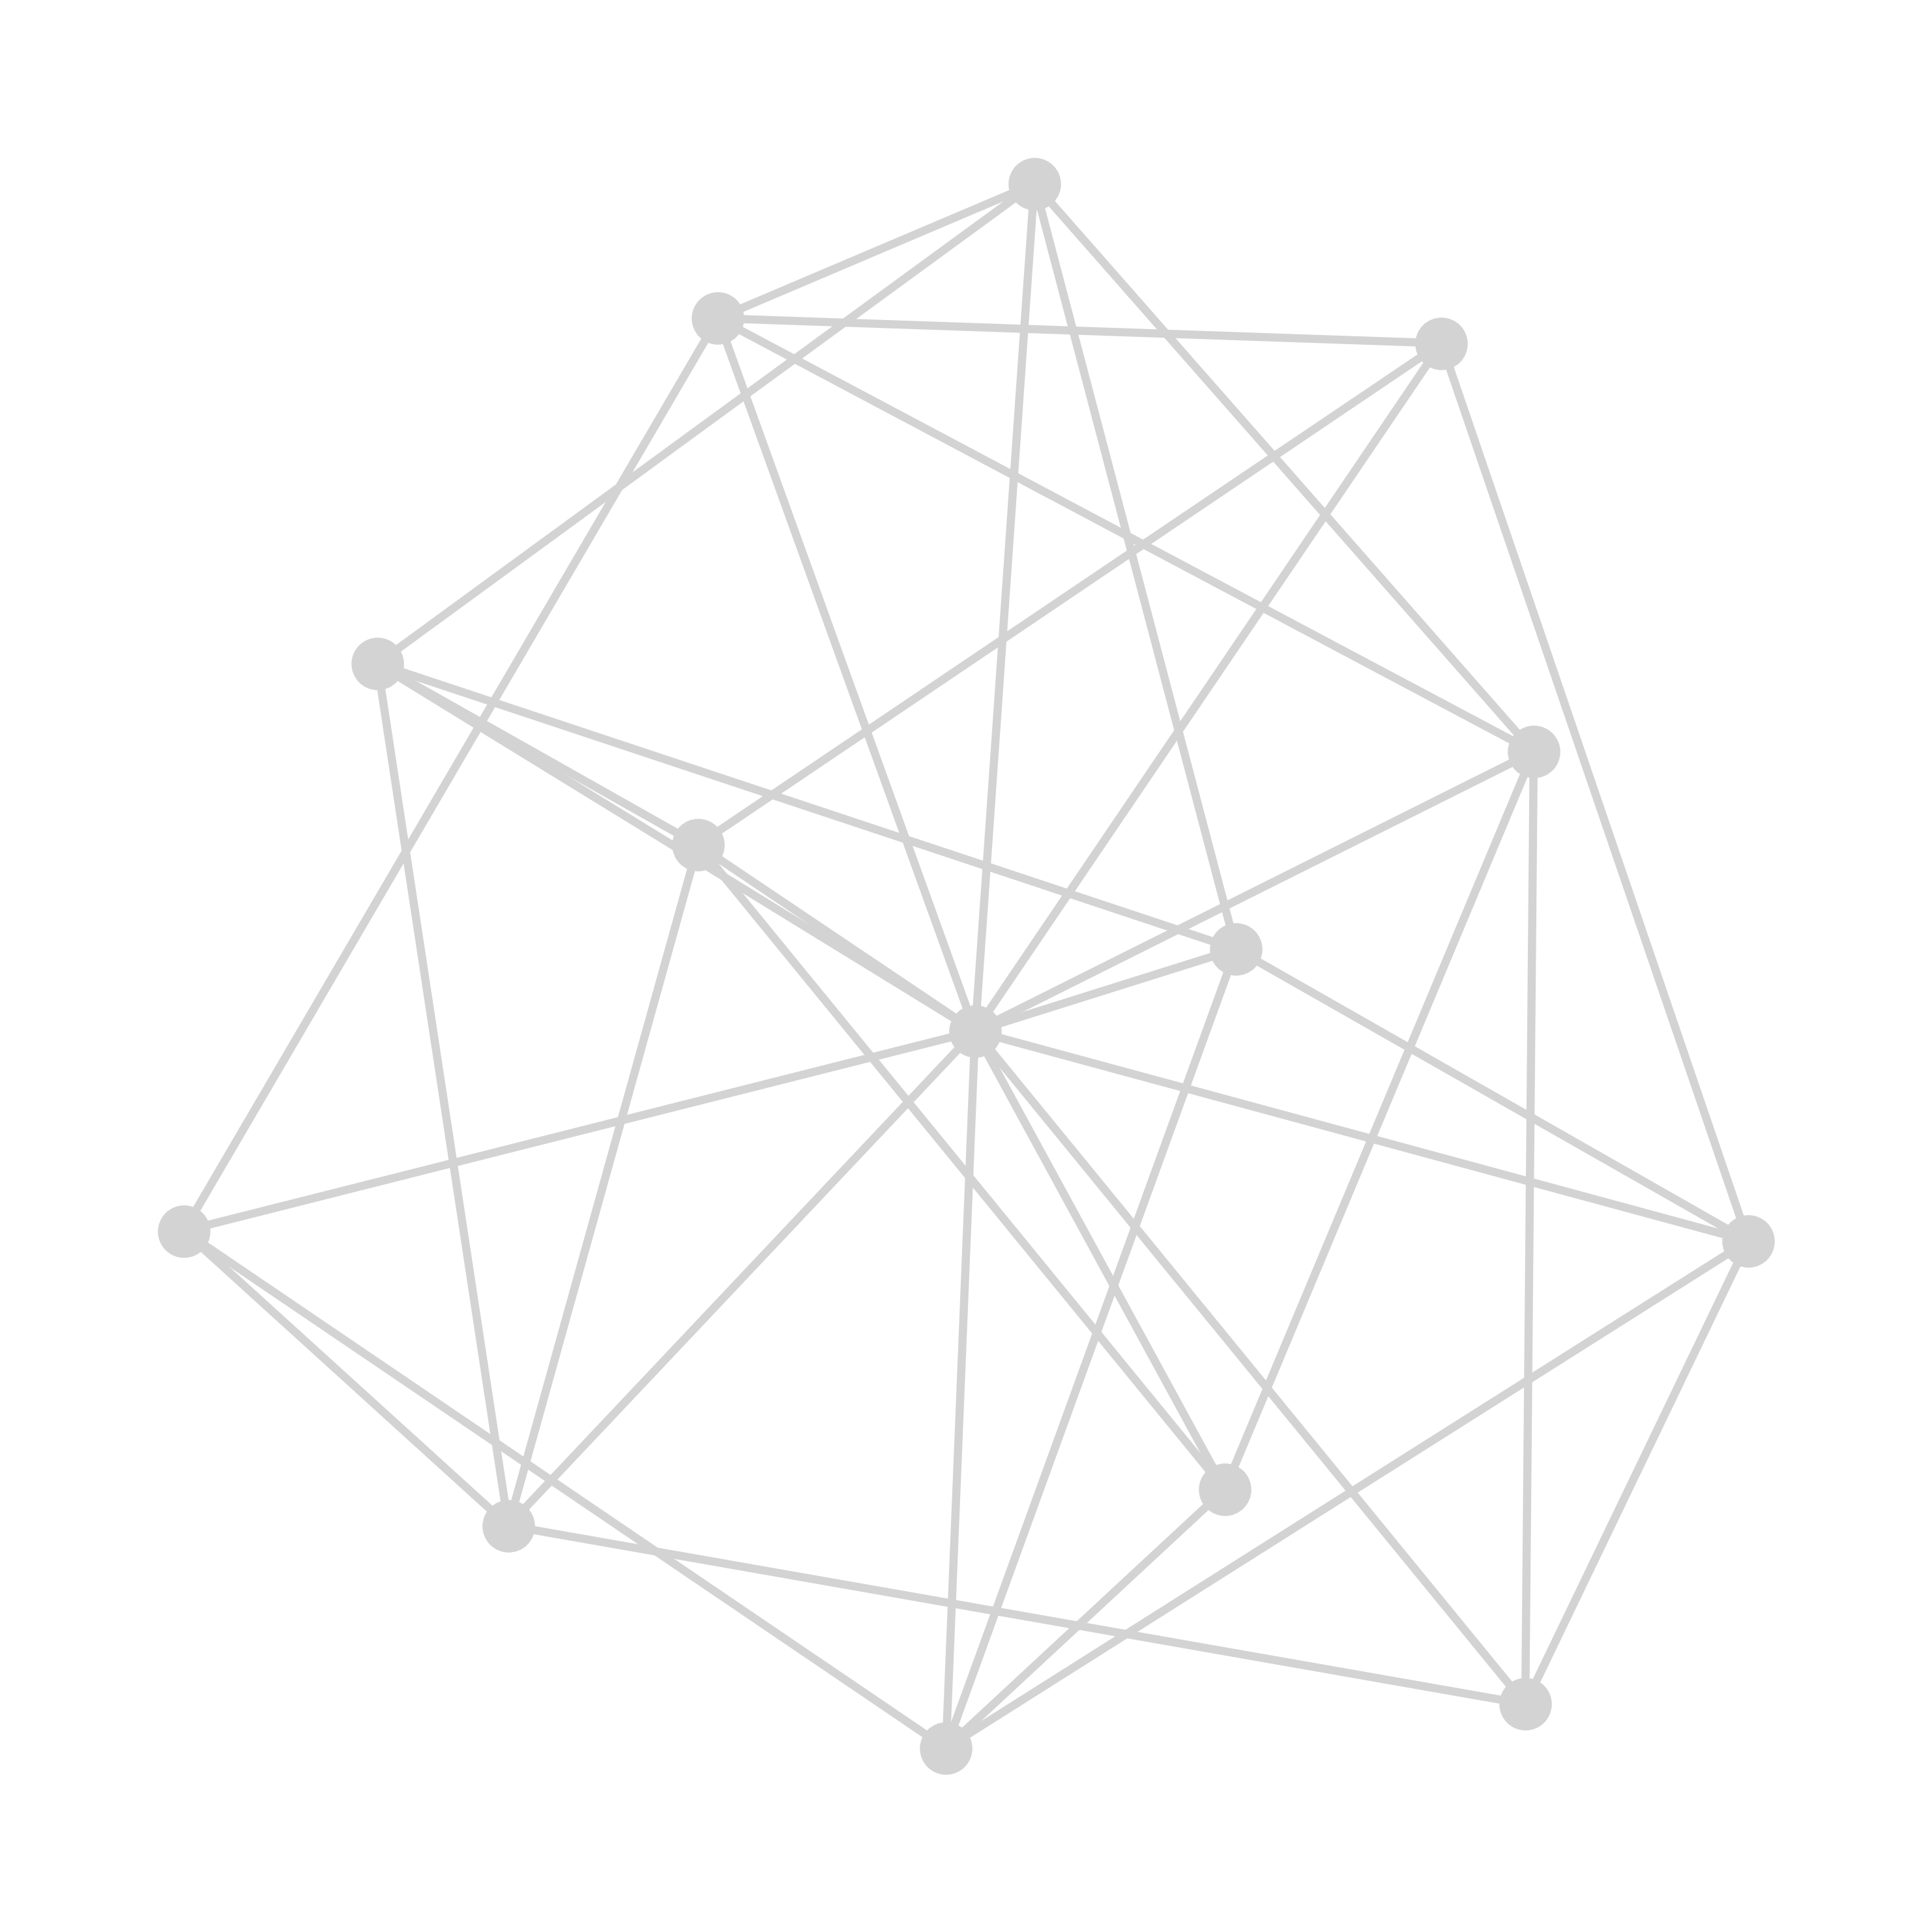

In [12]:
labels = ["a", "b", "c", "l", "m", "n", "p", "q", "r", "w", "x", "y", "z", r"$\alpha$"]
G = G14._get_graph()

plt.figure(figsize=(26 / 2.5, 26 / 2.5), dpi=300)
nx.draw_networkx(
    G,
    with_labels=False,
    edge_color="#D3D3D3",
    node_color="#D3D3D3",
    width=3
)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig("poster_figures/g14.svg", transparent=True)

## Plot Noise Simulation

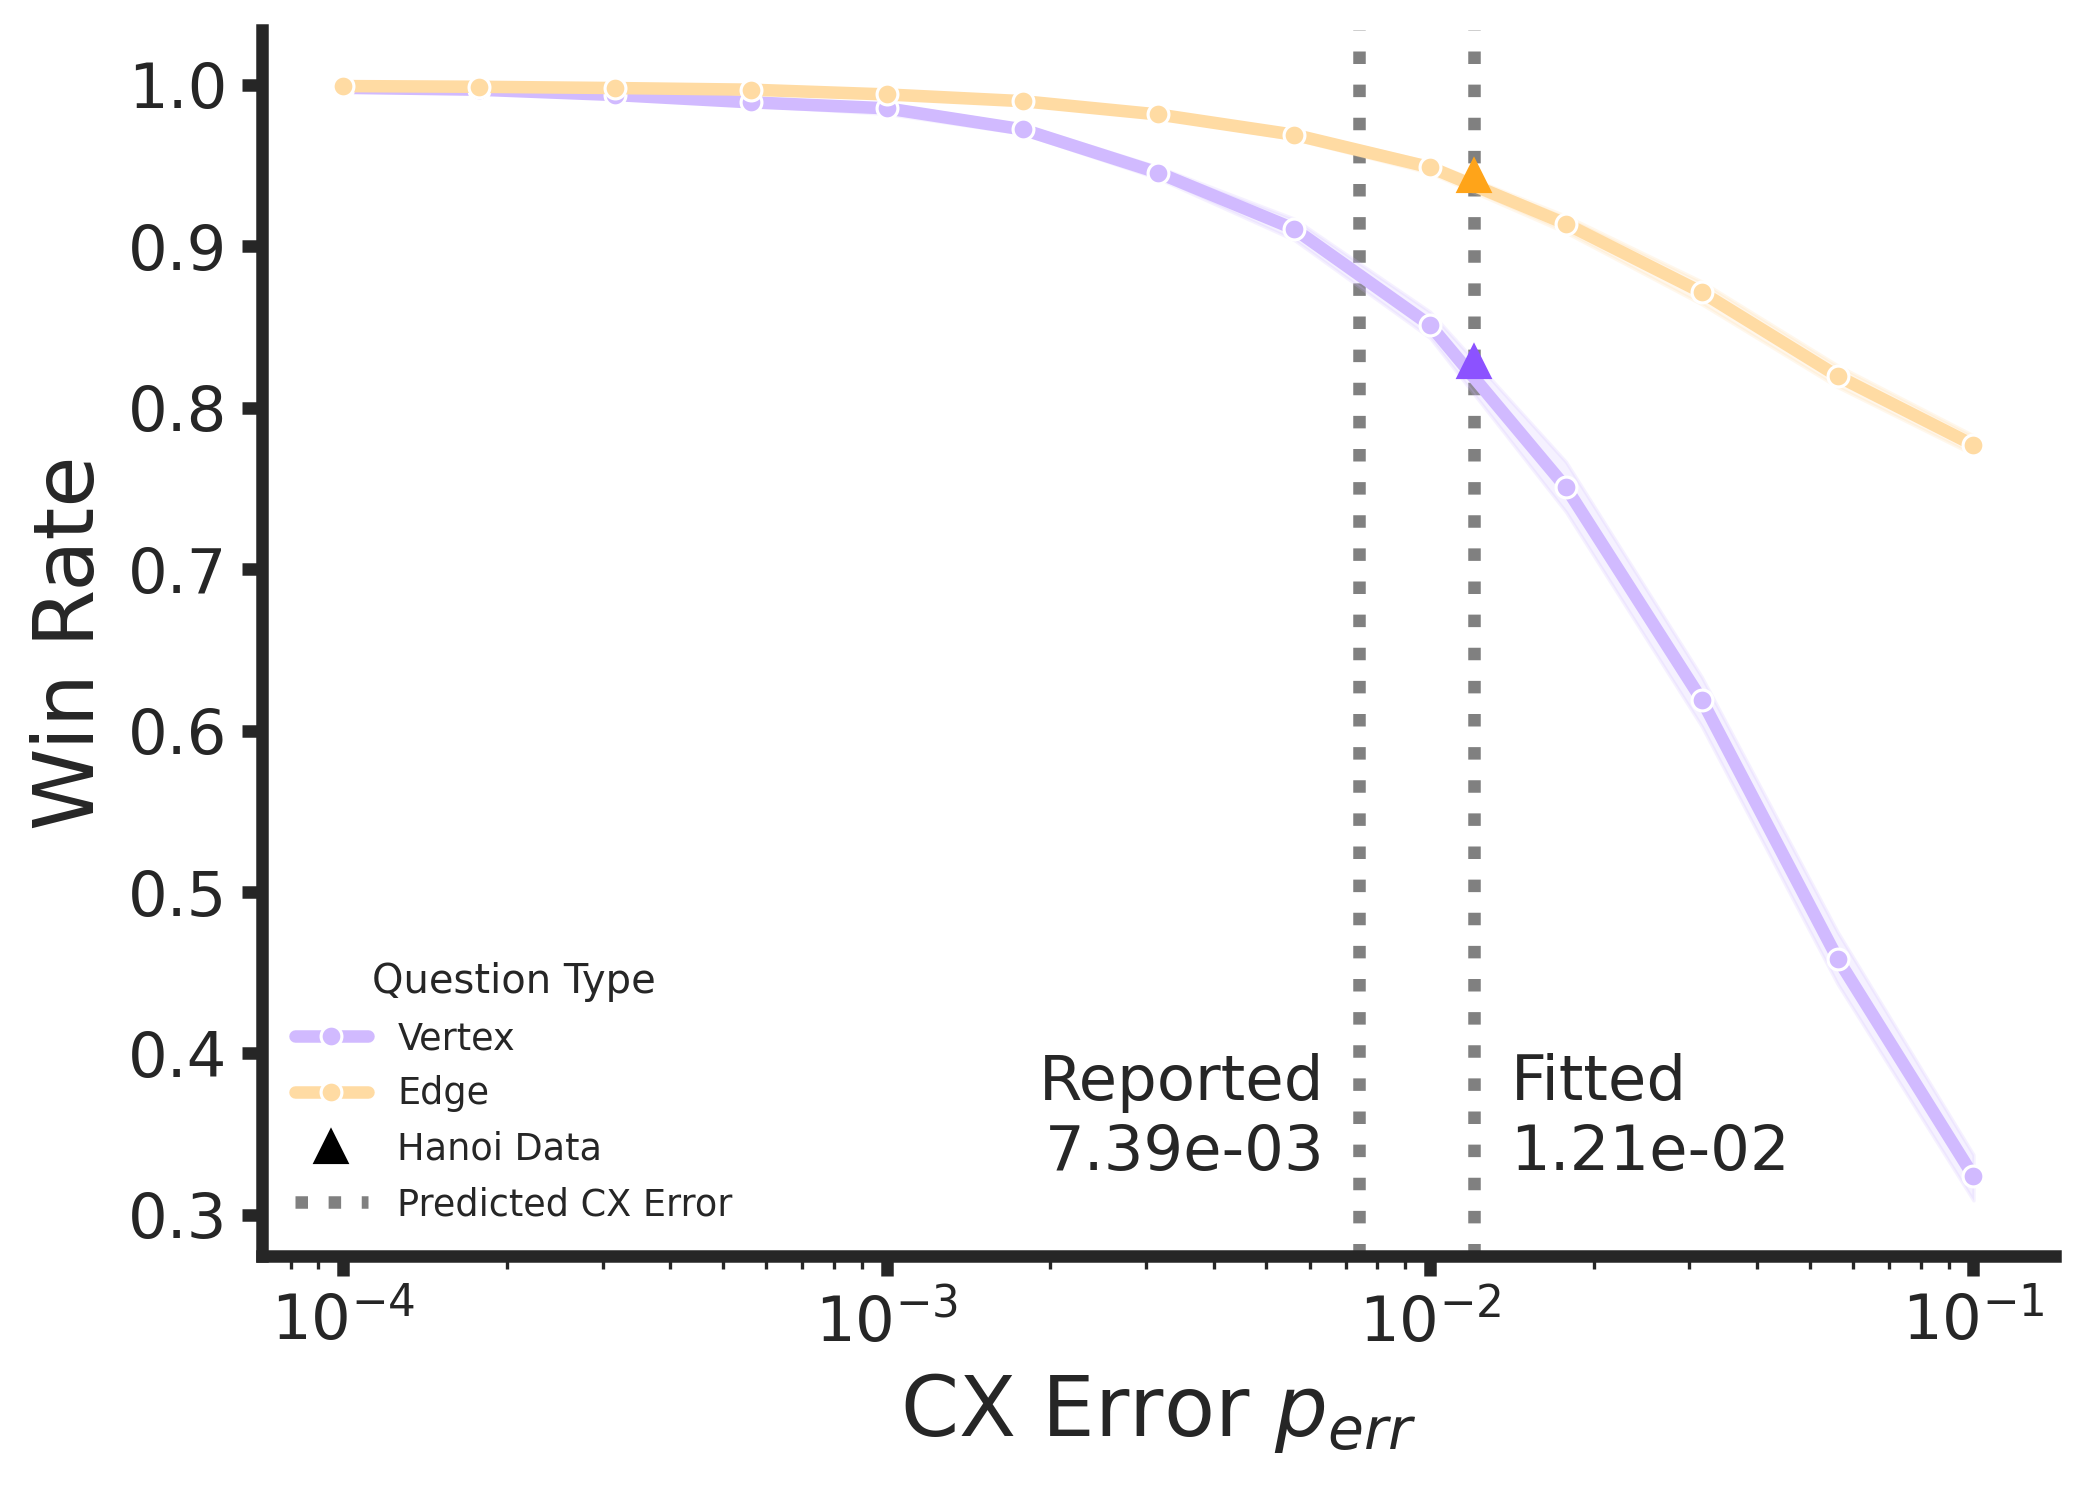

In [32]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('ticks')
sns.set_context('paper')

plt.rc('font', size=15)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

light_palette = ('#D1BAFF', '#FFDBA3')
dark_palette = ('#8C52FF', '#FFA419')

fig = plt.figure(figsize=(7.2, 5.2), dpi=300)
ax = plt.gca()
df = pd.read_csv('data/zne/simulated_noise_hanoi.csv')
df['qtype'] = np.where(df.va == df.vb, 'Vertex', 'Edge')

with sns.color_palette(light_palette):
    g = sns.lineplot(
        data=df,
        x='p_err',
        y='p_win',
        hue='qtype',
        marker='o',
        ax=ax,
        linewidth=3,
        markersize=5
    )

# Plot hanoi data
real_data = pd.read_csv('data/g14_constrained_u3ry/ibm_processed.csv')
real_data = real_data.loc[real_data.backend == 'ibm_hanoi', ['qtype', 'q_winrate']]

real_dw = (real_data.loc[real_data.qtype == 'Edge'].q_winrate.mean() -
            real_data.loc[real_data.qtype == 'Vertex'].q_winrate.mean())

reported_cx_err = 7.395e-3

def get_error_func():
    vertex_df = df.loc[df.qtype == 'Vertex'].copy()
    vertex_df.sort_values('p_err')
    mean_vertex_df = vertex_df.groupby('p_err').mean(numeric_only=True).reset_index()
    sigma_vertex_df = vertex_df.groupby('p_err').std(numeric_only=True).reset_index()
    x_v, y_v = mean_vertex_df.p_err.values, mean_vertex_df.p_win.values
    sigma_y_v = sigma_vertex_df.p_win.values

    edge_df = df.loc[df.qtype == 'Edge'].copy()
    edge_df.sort_values('p_err')
    mean_edge_df = edge_df.groupby('p_err').mean(numeric_only=True).reset_index()
    sigma_edge_df = edge_df.groupby('p_err').std(numeric_only=True).reset_index()
    x_e, y_e = mean_edge_df.p_err.values, mean_edge_df.p_win.values
    sigma_y_e = sigma_edge_df.p_win.values

    # y_v_mean = real_data.loc[real_data.qtype == 'Vertex', 'q_winrate'].mean()
    # y_e_mean = real_data.loc[real_data.qtype == 'Edge', 'q_winrate'].mean()

    def error_prob(cx_err):
        pred_y_e = np.interp(cx_err, x_e, y_e)
        pred_y_v = np.interp(cx_err, x_v, y_v)
        dw = pred_y_e - pred_y_v

        pred_sigma_e = np.interp(cx_err, x_e, sigma_y_e)
        pred_sigma_v = np.interp(cx_err, x_v, sigma_y_v)
        sigma_dw = np.sqrt(pred_sigma_e ** 2 + pred_sigma_v ** 2)

        z = (real_dw - dw) / sigma_dw
        p = stats.norm.pdf(z)
        return -p

        # dist = (pred_y_e - y_e_mean) ** 2 + (pred_y_v - y_v_mean) ** 2
        # return np.sqrt(dist)

    return error_prob

res = minimize(get_error_func(), reported_cx_err)
optimal_cx_err = res.x

with sns.color_palette(dark_palette):
    plt.plot(
        optimal_cx_err,
        real_data.loc[real_data.qtype=='Vertex'].q_winrate.mean(),
        '^', color=dark_palette[0], label='Hanoi Data', markersize=7
    )

    plt.plot(
        optimal_cx_err,
        real_data.loc[real_data.qtype=='Edge'].q_winrate.mean(),
        '^', color=dark_palette[1], markersize=7
    )

ylim = plt.ylim()
plt.vlines(optimal_cx_err, *ylim, label='Predicted CX Error', linestyles='dotted', colors='gray', zorder=-1, linewidth=3)
plt.vlines(reported_cx_err, *ylim, linestyles='dotted', colors='gray', zorder=-1, linewidth=3)
plt.text(reported_cx_err - 1e-3, 0.4, f'Reported\n{reported_cx_err:.2e}',
        horizontalalignment='right', verticalalignment='top')
plt.text(optimal_cx_err + 2e-3, 0.4, f'Fitted\n{optimal_cx_err.item():.2e}',
         horizontalalignment='left', verticalalignment='top')
plt.ylim(*ylim)

legend = plt.legend()
legend.set_title('Question Type')
legend.get_lines()[2].set_color('black')
legend.get_frame().set_linewidth(0.0)
plt.xlabel(r'CX Error $p_{err}$')
plt.xscale('log')
plt.ylabel('Win Rate')
sns.despine()

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
ax.tick_params(width=3)

plt.tight_layout()
plt.savefig('poster_figures/simulated_noise.svg', transparent=True)
plt.show()

## Plotting benchmark on all devices

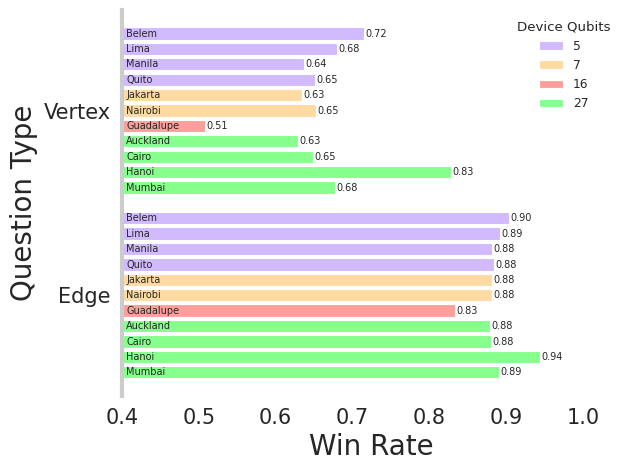

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.axes import Axes
import numpy as np
import pandas as pd

custom_palette = ('#D1BAFF', '#FFDBA3', '#FF9F9B', '#87FF8D')
sns.set_context('paper')
sns.set_palette(custom_palette)
sns.set_style('whitegrid')
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

df = pd.read_csv('data/g14_constrained_u3ry/ibm_processed.csv')
df['Device'] = df.backend.apply(lambda s: s.split('_')[1].title())
df.sort_values(by=['qubits', 'Device'])
qubit_values = df.qubits.unique().tolist()
qubit_values = sorted(qubit_values)
devices = df.Device.unique()

fig = plt.figure()
ax: Axes = plt.gca()

qubit_artists = []

i = 0
for color_idx, qubits in enumerate(qubit_values):
    data: pd.DataFrame = df.loc[df.qubits == qubits]
    data.sort_values('Device')
    subdevices = np.sort(data.Device.unique())

    # plot one question type
    y = -1 * (np.arange(len(subdevices)) + i)
    tmp = data.loc[data.qtype == 'Vertex'].groupby('Device').mean(numeric_only=True)
    container = ax.barh(
        y,
        tmp.q_winrate,
        color=f'C{color_idx}',
        align='center',
        height=0.8
    )

    qubit_artists.append(container.patches[0])
    ax.bar_label(
        container,
        fmt='%.2f',
        fontsize=7,
        padding=1
    )

    for dev, y_val in zip(subdevices, y):
        ax.text(0.405, y_val, dev,
                fontsize=7,
                horizontalalignment='left',
                verticalalignment='center')

    # Plot the other
    y = -1 * (np.arange(len(subdevices)) + i + len(devices) + 1)
    tmp = data.loc[data.qtype == 'Edge'].groupby('Device').mean(numeric_only=True)
    container = ax.barh(
        y,
        tmp.q_winrate,
        color=f'C{color_idx}',
        align='center',
        height=0.8
    )

    ax.bar_label(
        container,
        fmt='%.2f',
        fontsize=7,
        padding=1
    )

    for dev, y_val in zip(subdevices, y):
        ax.text(0.405, y_val, dev,
                fontsize=7,
                horizontalalignment='left',
                verticalalignment='center')

    i += len(subdevices)

plt.xlabel('Win Rate')
plt.xlim(0.4, 1.05)

n = len(devices)
plt.yticks([-n // 2 + 1, -3 * n // 2], ['Vertex', 'Edge'])
plt.ylabel('Question Type')
plt.grid(visible=False, axis='y')

legend = ax.legend(
    qubit_artists,
    [f'{int(q)}' for q in qubit_values],
    title='Device Qubits',
    framealpha=1
)
legend.get_frame().set_linewidth(0.0)
ax.grid(False)
sns.despine(bottom=True)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
ax.tick_params(width=3)

plt.tight_layout()
plt.savefig('poster_figures/all_devices_byquestion.svg', transparent=True)
plt.show()